# 폐렴 진단기 성능개선

# Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경을 시도해보자.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [26]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않으며, 좌우 반전 정도의 augmentation만 도입해서 데이터를 추가해주자.

In [27]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [28]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [29]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 나와있다
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person26_bacteria_122.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person670_virus_1256.jpeg


In [30]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 수를 알 수 있다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 수를 알 수 있다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1088
Pneumonia images count in training set: 3097


In [31]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [32]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [33]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [34]:
# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [35]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [37]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [38]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 해보자. \
만약 augmentation을 시도했다면 이후 실습 코드에 있는 `show_batch()` 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해보자.

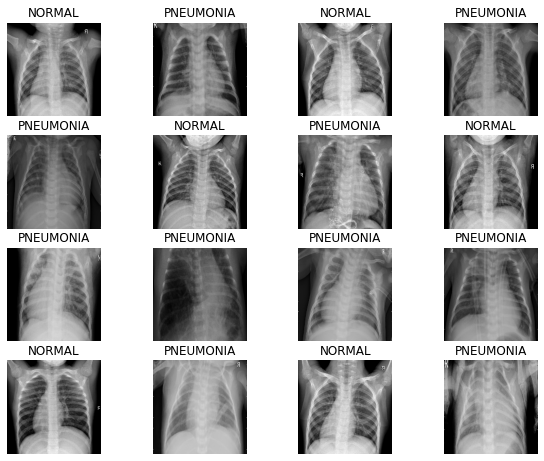

In [39]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 보자. 
- Convolution filter, 
- 채널 개수, 
- activation, 
모델 구조 등을 다양하게 바꾸어볼 수 있다.

예제에서 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했으며, 이것은 일반적으로 잘 사용되는 형태는 아니다. \
하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다. \
만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 보자. \
BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있으며, Dropout 비율을 변경해볼 수도 있다.

In [40]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [41]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [52]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
#         dense_block(32, 0.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었다. \
만약 이러한 처리를 생략한다면 어떻게 되는지 살펴보자. \
또한 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 방법이 있는지 고민해보자.

In [53]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있다.

In [56]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [57]:
from keras.callbacks import EarlyStopping 

es=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience=5)

with tf.device('/GPU:0'):    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/20
261/261 [==============================] - 43s 136ms/step - loss: 0.5512 - accuracy: 0.7241 - precision: 0.9080 - recall: 0.6952 - val_loss: 0.6532 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 34s 132ms/step - loss: 0.2565 - accuracy: 0.8937 - precision: 0.9657 - recall: 0.8887 - val_loss: 1.5023 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 35s 134ms/step - loss: 0.2220 - accuracy: 0.9172 - precision: 0.9728 - recall: 0.9136 - val_loss: 0.1687 - val_accuracy: 0.9394 - val_precision: 0.9304 - val_recall: 0.9936
Epoch 4/20
261/261 [==============================] - 36s 138ms/step - loss: 0.1931 - accuracy: 0.9295 - precision: 0.9740 - recall: 0.9293 - val_loss: 0.1055 - val_accuracy: 0.9625 - val_precision: 0.9579 - val_recall: 0.9936
Epoch 5/20
261/261 [==============================] - 35s 135ms/step - loss: 0.1820 - accura

# Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해보자. \
우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요하다. \
훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지말자.

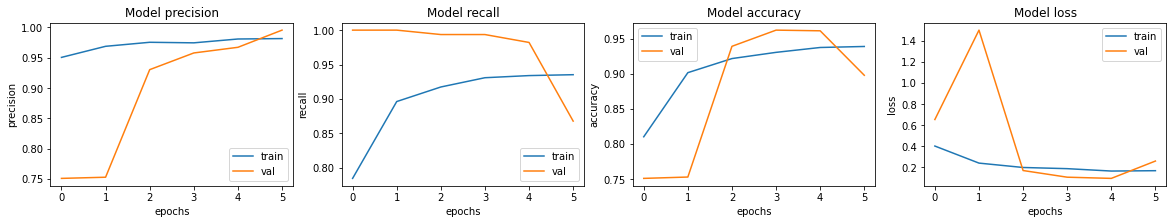

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [59]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 0.3399 - accuracy: 0.8670 - precision: 0.8790 - recall: 0.9128
Loss: 0.33990320563316345,
Accuracy: 0.8669871687889099,
Precision: 0.8790123462677002,
Recall: 0.9128205180168152


-----
# 정리
- model을  build할 때, 마지막 `tf.keras.layers.Dense(1, activation='sigmoid')`부분의 activation function을 relu로 변경해서 시도해보았더니, 학습이 되지 않고 오류가 생겼다.

변수들과 layer들의 변경.
- 첫번째 시도. epoch=50, batch_size=12, model에 `dense_block(32, 0.2)`를 추가해줬지만, 오히려 overfitting 문제가 생겼다.
- 두번째 시도. epoch=20, batch_size=12, model `dense_block(32, 0.2)`그대로 유지. 여전히 overfitting.
- 세번째 시도. epoch=20, batch_size=12, model `dense_block(32, 0.2)`그대로 유지. 여전히 overfitting.
recall값은 80이 넘었고, loss는 1.53..., Accuracy: 0.7..., Precision: 0.6.... 으로 다소 저조한 성과를 보였다.
- 네번째 시도. epoch=20, batch_size=12, model `dense_block(32, 0.2)` 제거. 여전히 overfitting.
recall값은 86이 넘었고, loss는 1.33..., Accuracy: 0.6..., Precision: 0.78.... 으로 다소 저조한 성과를 보였다.
- 다섯번째 시도. epoch=20, batch_size=12, early_stopping을 추가해줬다. monitor는 val_recall이 max값 찍은 상태를 10번 이상 반복하면 멈추도록 설정해줬다.
recall값은 80대에서 그쳤으며 loss, accuracy, precision은 여전히 저조한 성과를 보인다
- 여섯번째 시도. epoch=20, batch_size=16. early_stopping의 monitor를 val_precision이 max값 찍은 상태를 10번 이상 반복하면 멈추도록 설정해줬다.
epoch : 1에서 끝나버렸다.... precision이 1이 되버렸기 때문이다.
- 일곱번째 시도. epoch=20, batch_size=16. early_stopping의 monitor를 val_recall으로 돌려놨으며 max값 찍은 상태를 5번 이상 반복하면 멈추도록 설정해줬다.
```
Loss: 0.33990320563316345,
Accuracy: 0.8669871687889099,
Precision: 0.8790123462677002,
Recall: 0.9128205180168152
```
드디어 recall값이 90이 넘었으며, loss,accuracy, precision전부 만족스러운 성과를 보였다.
